# Remote resource monitor
This ia a remote resource monitor in a notebook. It can be very frustrating to see no output for a long time: is your script actually running or did your kernel die in the background. This remote resource monitor will let you know by plotting the CPU, RAM and video memory.

## Requirements
- Matplotlib   
 - `pip install matplotlib`
- PSUtil
 - `pip install psutil`
- pynvml (for GPU) 
 - `pip install py3nvml`

In [33]:
show_gpu_mem = True
show_gpu_mem_max = False

cpu_color = "deepskyblue"
memory_color = "darkorange"
gpu_color = "yellowgreen"

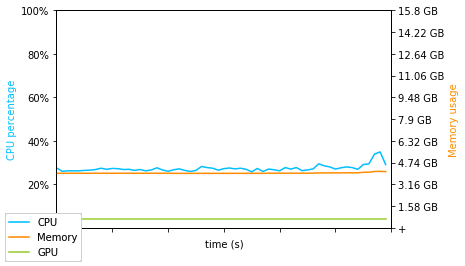

In [ ]:
%matplotlib inline
import psutil
import matplotlib.pyplot as plt
import time
import math
import numpy as np
from IPython import display
if show_gpu_mem:
    from py3nvml.py3nvml import *
    nvmlInit()

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def pad_input(y_series, length):
    padding = length - len(y_series)
    y_series.extend([None for i in range(padding)])
    return y_series

cpu_percent = []
mem_used = []


if show_gpu_mem:
    gpu_used = []
    gpu_total = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).total
    gpu_yticks = [0.1*gpu_total * i for i in range(0, 11)]
    gpu_yticks_label = [""]+[convert_size(tick) for tick in gpu_yticks[1:]]
    
vm_total, _, _, vm_used, _ = list(psutil.virtual_memory())

cpu_yticks = range(0, 110, 20)
cpu_yticks_label = ["{}%".format(per) for per in cpu_yticks]

mem_yticks = [0.1*vm_total * i for i in range(0, 11)]
mem_yticks_label = ["+"]+[convert_size(tick) for tick in mem_yticks[1:]]

fig, ax1 = plt.subplots()

while True:
    try:
        # Update values
        cpu_percent += [psutil.cpu_percent()]
        if len(cpu_percent) > 60:
            cpu_percent.pop(0)
            
        mem_used += [list(psutil.virtual_memory())[3]]
        if len(mem_used) > 60:
            mem_used.pop(0)
            
        if show_gpu_mem:
            gpu_used += [nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).used]
            if len(gpu_used) > 60:
                gpu_used.pop(0)
            
        ax1.set_xlabel("time (s)")
        ax1.set_ylabel("CPU percentage", color=cpu_color)
        ax1.set_yticks(cpu_yticks)
        ax1.set_yticklabels(cpu_yticks_label)
        ax1.set_ylim(bottom=0, top=100)
        ax1.set_xticklabels([])
        ax1.set_xlim(0, len(gpu_used))

        ax2 = ax1.twinx()
        ax2.set_ylabel("Memory usage", color=memory_color)
        ax2.set_yticks(mem_yticks)
        ax2.set_yticklabels(mem_yticks_label, )
        ax2.set_ylim(bottom=0, top=vm_total)
        
        
        ax1.plot(range(60), pad_input(cpu_percent, 60), color=cpu_color, label="CPU", ) # fit the line
        ax2.plot(range(60), pad_input(mem_used, 60), color=memory_color, label="Memory") # fit the histogram
        if show_gpu_mem:
            ax2.plot(range(60), pad_input(gpu_used, 60), color=gpu_color, label="GPU")
            if show_gpu_mem_max:
                ax2.axhline(gpu_total, 0, 60, linestyle="dashed", color=gpu_color)
                ax2.annotate("Max GPU", (30, gpu_total+500000000), color=gpu_color)
        
        fig.legend(loc="lower left")

        # Update display
        display.display(fig)
        
        ax1.clear()
        ax1.set_yticks([])
        ax2.clear()
        ax2.set_yticks([])
        
        time.sleep(0.5)    #sleep
        display.clear_output(wait=True)

    except KeyboardInterrupt:
        fig.clear()
        display.set_matplotlib_close(True)
        display.clear_output(wait=False)
        display.display(fig)
        break
print("")